## Loading data into files and containers

In [57]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D

### Downloading data set should not need to do know


In [2]:
!chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && cp kaggle.json ~/.kaggle/ && echo 'Done'
!ls
!kaggle datasets download --force -d kmader/skin-cancer-mnist-ham10000

Done
kaggle.json  sample_data
100% 5.20G/5.20G [00:22<00:00, 257MB/s]
100% 5.20G/5.20G [00:22<00:00, 249MB/s]


In [3]:
archive = 'skin-cancer-mnist-ham10000.zip'
cur_dir = os.getcwd()
a = os.path.join(cur_dir, archive)
os.listdir()

['.config', 'kaggle.json', 'skin-cancer-mnist-ham10000.zip', 'sample_data']

In [4]:
with ZipFile(archive , 'r') as zip_ref:
    zip_ref.extractall('./')

In [5]:
path_1 = 'HAM10000_images_part_1'
path_2 = 'HAM10000_images_part_2'
path_meta = 'HAM10000_metadata.csv'

### Read data

In [6]:
file_path1 = os.path.join(cur_dir, path_1) #HAM10000_images_part_1
file_path2 = os.path.join(cur_dir, path_2) #HAM10000_images_part_2

len(os.listdir(file_path1)), len(os.listdir(file_path2))

(5000, 5015)

In [7]:
metadata_path = os.path.join(cur_dir, path_meta)
df = pd.read_csv(metadata_path)
df['lesion_id'].unique().shape, df

##
df_ids_img = df[['lesion_id','image_id','dx']]
df_ids_img['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

This shows that we have 7470 unique images and duplicates that are either different views or magnified.

### First folder processing

In [26]:
num_1 = int( len(os.listdir(file_path1)) / 2 ) # Number of images to use

In [27]:
imgs_1 = [ np.zeros((450,600,3),'float32') for k in  range( num_1 ) ]
len(imgs_1)

2500

In [28]:
target = np.zeros( num_1 ).astype('str') # Convert to int later

target.shape, 

((2500,),)

In [29]:
sizes = []
min = 100
max = -1

for img in imgs_1:
    if( img.shape not in sizes ):
        sizes.append(img.shape)
sizes

[(450, 600, 3)]

In [30]:
size = (200,200)
for i, img in enumerate( os.listdir(file_path1) ): #Loop through each file
    if( i < 2500 ):
        p_id = img.split('.')[0]#Extract id
        target[i] = df[ df['image_id'] == p_id ]['dx'].iloc[0] # Target Feature
        imgs_1[i] = cv.resize( cv.imread( os.path.join(file_path1, img) ), size ) # Load data into array 
        # May want to change the color scheme, but we will see                   

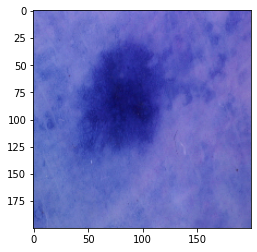

In [31]:
plt.imshow(imgs_1[0])

### normalize images

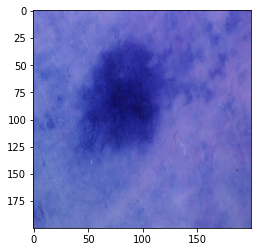

In [32]:
imgs_1_norm = [ img / 255.0 for img in imgs_1 ]
plt.imshow(imgs_1_norm[0])

### Shuffle data


In [33]:
# Put targets and photos together
group_1 = [0 for i in range(num_1)]
for i in range(num_1):
    group_1[i] = [ imgs_1_norm[i], target[i] ]

In [34]:
# Shuffle
np.random.shuffle(group_1)

# Ungroup
for i in range(num_1):
    imgs_1_norm[i] = group_1[i][0]
    target[i] = group_1[i][1]
    

In [35]:
np.array(imgs_1_norm).shape

(2500, 200, 200, 3)

:### Convert target feature into numerical data  Format Data

In [36]:
target_dict = {'bkl': 1, 'nv': 2, 'df': 3, 'mel': 4, 'vasc': 5, 'bcc': 6, 'akiec': 7}
for k in range(14):
    print( target[k] )
 
# One-hot encode the targets
target_ohe = np.zeros((num_1, len(target_dict)))
target_ohe.shape
for i in range(num_1):
    idx = target_dict[target[i]] - 1
    target_ohe[i][idx] = 1

for k in range(10):
    print(target_ohe[k])

#imgs_1_norm = [k.flatten() for k in imgs_1_norm]
# Not useful probably
#target= [ target_dict[t] for t in target ]
#for k in range(14):
#    print( target[k] )



mel
nv
nv
mel
mel
nv
nv
nv
nv
nv
bkl
bkl
nv
nv
[0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]


In [37]:
cnt = [0 for k in range(7)]
for k in target:
    cnt[target_dict[k] - 1] += 1
cnt[0] + cnt[2] + cnt[3]+ cnt[4]+ cnt[5] + cnt[6], cnt[1]

(763, 1737)

Notice that data is skewed towards non-cancerous pictures

### Split data

In [38]:
train_split = int ( num_1 * 0.8 )
train_x = np.array(imgs_1_norm[:train_split])
train_y = np.array(target_ohe[:train_split])

val_x = np.array(imgs_1_norm[train_split:])
val_y = np.array(target_ohe[train_split:])

In [39]:
# one-hot encode the targets

### Model

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D

filter1 = 16
filter2 = 32
filter3 = 64

input_size = (size[0], size[1], 3)
pool_size = (2,2)

#First make our layers
input_layer = tf.keras.layers.Input(shape = input_size, name = 'input')
conv1 = Conv2D(filter1, (8,8), activation='relu', padding='same', name = 'c1')(input_layer)
pool1 = MaxPool2D(pool_size, name = 'p1')(conv1)
conv2 = Conv2D(filter2, (4,4), activation = 'relu', padding = 'same', name = 'c2')(pool1)
pool2 = MaxPool2D(pool_size, name = 'p2')(conv2)
conv3 = Conv2D(filter3, (2,2), activation = 'relu', padding = 'same', name = 'c3')(pool2)
pool3 = MaxPool2D(pool_size, name = 'p3')(conv3)
flatten = tf.keras.layers.Flatten(name = 'flatten')(pool3)
dense1 = Dense(256,activation = 'relu',name = 'd1')(flatten)
output_layer = Dense(7, activation = 'softmax',name = 'out')(dense1) # Change output and possibly above line

In [45]:
model1 = tf.keras.Model(input_layer, output_layer, name = 'Model1')

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
model1.compile(
    optimizer = 'Adam',
    loss = 'categorical_crossentropy', # Multiclass Problem
    metrics = 'accuracy',
)

model1.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 200, 3)]     0         
                                                                 
 c1 (Conv2D)                 (None, 200, 200, 16)      3088      
                                                                 
 p1 (MaxPooling2D)           (None, 100, 100, 16)      0         
                                                                 
 c2 (Conv2D)                 (None, 100, 100, 32)      8224      
                                                                 
 p2 (MaxPooling2D)           (None, 50, 50, 32)        0         
                                                                 
 c3 (Conv2D)                 (None, 50, 50, 64)        8256      
                                                                 
 p3 (MaxPooling2D)           (None, 25, 25, 64)        0    

In [46]:
train_x.shape

train_y.shape,train_x.shape

((2000, 7), (2000, 200, 200, 3))

In [47]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', patience = 5
    )

EPOCH = 100

#Train the model
history = model1.fit(
    train_x,
    train_y,
    epochs = EPOCH,
    batch_size = 1028,
    callbacks = [early_stop]
)

Epoch 1/100
2/2 [==============================] - 15s 3s/step - loss: 3.0575 - accuracy: 0.3485
Epoch 2/100
2/2 [==============================] - 1s 540ms/step - loss: 1.8565 - accuracy: 0.4225
Epoch 3/100
2/2 [==============================] - 1s 548ms/step - loss: 1.3758 - accuracy: 0.6935
Epoch 4/100
2/2 [==============================] - 1s 555ms/step - loss: 1.1636 - accuracy: 0.6935
Epoch 5/100
2/2 [==============================] - 1s 544ms/step - loss: 1.1977 - accuracy: 0.6925
Epoch 6/100
2/2 [==============================] - 1s 547ms/step - loss: 1.0677 - accuracy: 0.6935
Epoch 7/100
2/2 [==============================] - 1s 546ms/step - loss: 1.0619 - accuracy: 0.6935
Epoch 8/100
2/2 [==============================] - 1s 556ms/step - loss: 1.0633 - accuracy: 0.6935


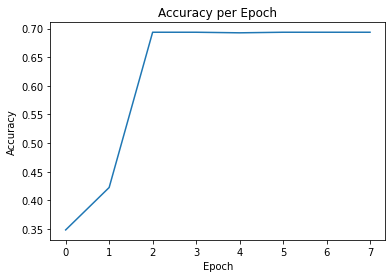

In [48]:
import matplotlib.pyplot as plt

plt.title("Accuracy per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(0,len(history.history['accuracy'])), history.history['accuracy'])


In [59]:
predictions = model1.predict(val_x)
predictions[0]

array([0.13693689, 0.5050614 , 0.04372618, 0.10914077, 0.04677097,
       0.07787201, 0.08049188], dtype=float32)

(array([[280., 220.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,  32.,  91.,  65.,  52.,  96., 116.,  48.],
        [500.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [293., 207.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [500.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [451.,  49.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [444.,  56.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([0.00196638, 0.09587513, 0.18978387, 0.28369263, 0.3776014 ,
        0.4715101 , 0.5654189 , 0.6593276 , 0.75323635, 0.84714514,
        0.94105387], dtype=float32),
 <a list of 7 Lists of Patches objects>)

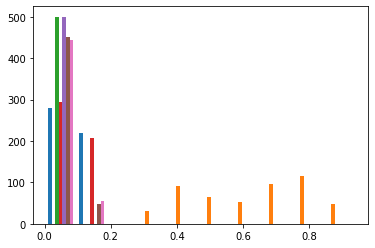

In [51]:
plt.hist(predictions)

In [58]:
prediction = [int(round(k[0])) for k in predictions]

acc = accuracy_score( prediction, val_x )

print(f'Accuracy is {acc}')

#f1 = f1_score(val_y, prediction)
#prec = precision_score(val_y, prediction)
#rec = recall_score(val_y, prediction)

#print(f'The f1 score is {f1} the \n \
#        precision is {prec} and the \n \
#        recall is {rec}')

ValueError: ignored

# Trying by identifying if a lesion is cancerous or not, disregarding type